# Braintriage challenge example

# Import packages
Here we import important packages. Add any packages you need.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as math
import csv


# Create dataset
First we select slices from the full dataset. Here we show an example where the center slice is selected for the T1, T2 and T2-FLAIR scan. These are combined in a torch tensor to allow for quick processing by the network.

In [2]:
in_dir = '/projects/0/ismi2018/BrainTriage/train/full'
out_dir = './data'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

Slices saved for: 239
Slices saved for: 1913
Slices saved for: 1541
Slices saved for: 104
Slices saved for: 1485
Slices saved for: 168
Slices saved for: 1251
Slices saved for: 318
Slices saved for: 1290
Slices saved for: 891
Slices saved for: 993
Slices saved for: 1679
Slices saved for: 585
Slices saved for: 711
Slices saved for: 1119
Slices saved for: 606
Slices saved for: 819
Slices saved for: 1893
Slices saved for: 797
Slices saved for: 1343
Slices saved for: 1368
Slices saved for: 1958
Slices saved for: 2002
Slices saved for: 171
Slices saved for: 1190
Slices saved for: 21
Slices saved for: 2046
Slices saved for: 1209
Slices saved for: 324
Slices saved for: 1597
Slices saved for: 1945
Slices saved for: 1909
Slices saved for: 1431
Slices saved for: 1839
Slices saved for: 613
Slices saved for: 1981
Slices saved for: 341
Slices saved for: 189
Slices saved for: 698
Slices saved for: 516
Slices saved for: 99
Slices saved for: 46
Slices saved for: 2230
Slices saved for: 1359
Slices saved

We create a dataset class that is compatible with the 'data_loader' from PyTorch. This allows us to feed our images to the network efficiently during training and validation. We read the labels for the different patients from a CSV file and convert this into a dictionary. Based on these labels we split the data in a training and validation set (you can choose a different ratio).

In [6]:
### Define custom dataset class ###
class Dataset(data.Dataset):
  #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, location):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.loc = location

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load(self.loc + '/' + ID + '.pt')#/2749
        y = torch.FloatTensor([self.labels[ID]])

        return X, y

### Specify data directory ###    
data_dir = './data'

### Load labels and convert to dict ###
labelsn = {}
labelsa = {}

n=0
a=0

with open(data_dir+'/labels_slices_z.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        if float(rows[1])==0 and n<500:
            n = n+1
            labelsn[rows[0]] = float(rows[1])
        elif float(rows[1])==1 and a<500:
            a = a+1
            labelsa[rows[0]] = float(rows[1])
labels = {**labelsn,**labelsa}
            
### Based on the labels, split data in training and validation set ###
IDn = np.asarray(list(labelsn.keys()))
IDa = np.asarray(list(labelsa.keys()))
n_samples = IDa.shape[0]

IDn = IDn[np.random.permutation(n_samples)]
IDa = IDa[np.random.permutation(n_samples)]

data_sets = {}
data_sets['train'] = np.concatenate((IDn[:int(0.8*n_samples)],IDa[:int(0.8*n_samples)]))
data_sets['validation'] = np.concatenate((IDn[int(0.8*n_samples):],IDa[int(0.8*n_samples):]))

training_set = Dataset(data_sets['train'], labels, data_dir)
validation_set = Dataset(data_sets['validation'], labels, data_dir)


You can visually inspect the data by making a plot of a scan.

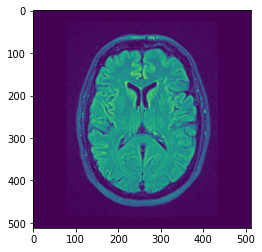

In [7]:
import matplotlib
import matplotlib.pyplot as plt

X = torch.load(data_dir + '/' + '16' + '.pt')#/2749

plt.figure()
plt.imshow(X.data.numpy()[2,:,:])

# Defining the model
Here we define a standard VGG-11 model that you can use as a baseline to compare your model against.

In [6]:
class Model(nn.Module):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool_5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adapool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.readout = nn.Linear(4096, outsize)

        self.in_channels = in_channels
        self.outsize = outsize
        
    def forward(self, x):
        h = self.conv1_1(x)
        h = self.bn1_1(h)
        h = F.relu(h)
        h = self.maxpool_1(h)
        h = self.conv2_1(h)
        h = self.bn2_1(h)
        h = F.relu(h)
        h = self.maxpool_2(h)       
        h = self.conv3_1(h)
        h = self.bn3_1(h)
        h = F.relu(h)
        h = self.conv3_2(h)
        h = self.bn3_2(h)
        h = F.relu(h)
        h = self.maxpool_3(h)       
        h = self.conv4_1(h)
        h = self.bn4_1(h)
        h = F.relu(h)
        h = self.conv4_2(h)
        h = self.bn4_2(h)
        h = F.relu(h)
        h = self.maxpool_4(h)
        h = self.conv5_1(h)
        h = self.bn5_1(h)
        h = F.relu(h)
        h = self.conv5_2(h)
        h = self.bn5_2(h)
        h = F.relu(h)
        h = self.maxpool_5(h)
        h = self.adapool(h)
        h = torch.flatten(h, 1)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        y = self.readout(h)

        return y
    

# Initialize model
Here we set the different training and model parameters. The model is initialized and a loss function and optimizer are choosen. Finally a training and validation iterator is created.

In [11]:
### Parameters ###
device = 1
epochs = 50
batch_size = 5
in_channels = 3
outsize = 1

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
model = Model(in_channels,outsize).cuda() # if device < 0 else Model(1,outsize).to_gpu(device)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

### Create data generator ###

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

NameError: name 'model' is not defined

# Resnet

In [18]:
from torchvision import models

### Parameters ###
device = 1
epochs = 50
batch_size = 5
in_channels = 3
outsize = 1

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, outsize)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.000001)

### Create data generator ###

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [8]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

# Training and validation
In the next cell the model is trained and validated. The loss is printed and the model is saved after every epoch.

In [23]:
### Training and validation ###
from torch.autograd import Variable
m =nn.Sigmoid()

loss_history = {'training': [], 'validation': []}
acc_history = {'training': [], 'validation': []}

for j in range(epochs):
    loss_history['training'].append(0)
    acc_history['training'].append(0)

    for i, batch in enumerate(training_iterator):

        resnet50.train() #model.train()

        images, targets = batch[0].cuda() , batch[1].cuda()
        print("hoi")
        y = resnet50(images) #model(images)
        print("hoi2")
        #print(y)
        loss = criterion(y,targets)

        optimizer.zero_grad()
        loss.backward()

        #print(list(model.parameters())[0].grad)
        optimizer.step()
        
        #Accuracy
        output = (m(y)>0.5).float()
        #print(output)

        correct = (output == targets).float().sum()/output.shape[0]

        loss_history['training'][-1] += float(loss.data)
        acc_history['training'][-1] += float(correct)

        #print(loss.data)
    loss_history['training'][-1] /= i + 1
    acc_history['training'][-1] /= i + 1

    loss_history['validation'].append(0)
    acc_history['validation'].append(0)

    for i, batch in enumerate(validation_iterator):

        resnet50.eval() #model.eval()
        
        images, targets = batch[0] , batch[1] #batch[0].cuda() , batch[1].cuda()

        y = resent50(images) #model(images)
        loss = criterion(y,targets)
        
        #Accuray
        output = (m(y)>0.5).float()
        correct = (output == targets).float().sum()/output.shape[0]
        #print(output)
        loss_history['validation'][-1] += float(loss.data)
        acc_history['validation'][-1] += float(correct)

    loss_history['validation'][-1] /= i + 1
    acc_history['validation'][-1] /= i + 1

    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.3f}, validation accuracy: {:.3f}.'.format(j + 1, epochs, loss_history['training'][-1], loss_history['validation'][-1], acc_history['training'][-1], acc_history['validation'][-1]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_dir, j), loss_history)
    torch.save(model.state_dict(), '{:s}/model_{:03d}.npz'.format(model_dir, j))

    

hoi


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Testing
Here we show some example code that you can use to run your model on the test data set once this is provided and create a .csv submission file that you can upload to grand challenge.

# Select slices for test set
Here we do the same as above to select slices from the test set.

In [14]:
in_dir = 'path/to/test_in_dir'
out_dir = 'path/to/test_out_dir'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z_test.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

Slices saved for: 2539
Slices saved for: 2813
Slices saved for: 2544
Slices saved for: 3058
Slices saved for: 2471
Slices saved for: 2495
Slices saved for: 2796
Slices saved for: 2348
Slices saved for: 2705
Slices saved for: 2608
Slices saved for: 3060
Slices saved for: 2557
Slices saved for: 2520
Slices saved for: 2427
Slices saved for: 2450
Slices saved for: 2654
Slices saved for: 2759
Slices saved for: 2518
Slices saved for: 2682
Slices saved for: 3073
Slices saved for: 2666
Slices saved for: 3079
Slices saved for: 3009
Slices saved for: 2481
Slices saved for: 2848
Slices saved for: 3083
Slices saved for: 3067
Slices saved for: 2571
Slices saved for: 2506
Slices saved for: 2826
Slices saved for: 2851
Slices saved for: 3022
Slices saved for: 2913
Slices saved for: 2433
Slices saved for: 2863
Slices saved for: 2633
Slices saved for: 2984
Slices saved for: 2530
Slices saved for: 2883
Slices saved for: 2917
Slices saved for: 2771
Slices saved for: 2496
Slices saved for: 2529
Slices save

We create a test dataset from these slices.

In [5]:
### Specify test data directory ###    
test_dir = '/path/to/test_out_dir'

### Load labels and convert to dict ###
labels_test = {}

with open(test_dir+'/labels_slices_z_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        labels_test[rows[0]] = float(rows[1])
           
data_sets['test'] = np.asarray(list(labels_test.keys()))

test_set = Dataset(data_sets['test'], labels_test, test_dir)


# Run trained model on the test set.
Run the model with the best validation loss on the test set to obtain a 'submission' csv file. You can upload this file to grand challenge to see how well you perform and add your score to the leaderboard.

In [11]:
test_iterator = data.DataLoader(test_set, batch_size=1, shuffle = False)

j = 4
model = Model(in_channels,outsize).cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
checkpoint = torch.load('{:s}/model_{:03d}.npz'.format(model_dir, j))

model.load_state_dict(checkpoint)
model.eval()
m =nn.Sigmoid()

with open(test_dir+'/submission.csv', 'a') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    w.writerow(['case','probability','class'])
    for i, batch in enumerate(test_iterator):
        images, targets = batch[0].cuda() , batch[1].cuda()
        y = model(images)
        prob = m(y)
        output = prob>0.5
        patient = data_sets['test'][i]
        w.writerow([patient, float(prob), int(output)])